### Spectrometer Control Notebook

This is the GUI version. All helper routines have been moved to the file `Helpers/Spectrometer.py` and get imported in the import statement below 📈.

In [ ]:
from Helpers.Spectrometer import *
%matplotlib inline

Call if you want LCD and NeoPixel support.

In [ ]:
initNeoPixel()

In [ ]:
initLCD()

## Lego Spectrometer Control
### Step 1 - Building the GUI

We are using `ipywidgets` to build a GUI to control the spectrometer.

In [224]:
def measure(b):

    time.value = strftime("%Y%m%d-%H%M%S") 
    shutter = int(1000000 * float(expo.value))
    raw = takePicture(shutter)

    ax = plt.gca()
    ax.grid(color='yellow', linestyle='dotted', linewidth=1)
    ax.set_xticks(np.arange(0, raw.width, 50.0))
    ax.imshow(raw)
    
    with out:
        clear_output(wait=True)
        display(ax.figure)
        

In [229]:
name   = widgets.Text(value='', placeholder='Scientist name', description='Scientist:', disabled=False)
light  = widgets.Text(value='', placeholder='Light source details', description='Light:', disabled=False)
sample = widgets.Text(value='', placeholder='Transmission sample details', description='Sample:', disabled=False)
notes  = widgets.Textarea(value='', placeholder='Experiment notes', description='Notes:', rows=6, disabled=False)
time   = widgets.Text(value='', placeholder='Timestamp', description='Timestamp:', disabled=False)

expo   = widgets.FloatSlider(value=1.0, min=0.0, max=6.0, step=0.1, description='Exposure:',
                             disabled=False, continuous_update=False, orientation='horizontal', readout=True,
                             readout_format='.1f')

button = widgets.Button(button_style='success', description='Measure', layout=widgets.Layout(width='30%'))
out    = widgets.Output(layout=widgets.Layout(width='600px', height='400px'))

right  = widgets.VBox(children=(time, name, light, sample, notes))
left   = widgets.VBox(children=(out, expo, button))
gui    = widgets.HBox(children=(left, right))

button.on_click(measure)

In [230]:
display(gui)

Allowing camera to warmup
Capturing image


In [ ]:
# Turn on the NeoPixel (skip if other light source is used)

pixels.fill((255,255,255))

In [ ]:
# Change these to match your experiment

lightSource        = "NeoPixel (255,255,255) - white"
scientistName      = "Thomas P"
transmissionSample = "None"
experimentNotes    = '''
Tracking paper between light entrance slit.
<b>Small slit.</b> 
'''
measurementTaken = strftime("%Y%m%d-%H%M%S") 

# Exposure time
shutter = 1000000

# Take the image, save and display
raw = takePicture(shutter)

### Step 2 - Cropping the image

Next we need to crop the image to just include the area showing the spectrum. We will first add a rectange to the image to show the current area. The crop region is given by the top left and bottom right points. **Keep ajusting the crop area and rerun this cell until the area only includes the 'good' part of the spectrum.**

In [ ]:
def cropImage(img,crop,angle):
    
    if(angle != 0.0):
        img = img.rotate(angle)
        
    temp = img.copy();
    draw = ImageDraw.Draw(temp)
    draw.rectangle(crop, outline=(0, 255, 0), width=2)
    
    # Show the crop area
    ax = plt.gca()
    ax.grid(color='yellow', linestyle='dotted', linewidth=1)
    plt.imshow(temp)
    
    return img.crop(crop)

In [ ]:
angle = 0.0
crop  = [0,200,250,290]

processed = cropImage(raw,crop,angle)

And here is the cropped images stored in the `processed` variable.

In [ ]:
# Setting up a fine grid to help with calibration 
ax = plt.gca()
ax.grid(color='yellow', linestyle='dotted', linewidth=1)
plt.xticks(np.arange(0, processed.width, 10.0))

plt.imshow(processed)

We can adjust the brightness of the picture to scale the highest color value to its maximum of 255.

In [ ]:
processed = adjustBrightness(processed)
processed

And show the image on the LCD screen

In [ ]:
disp.display(processed.resize((disp.width, disp.height)))

### Step 3 - Extracting spectum and converting to wavelength

Next we need to extract a 1D spectrum by averaging avlues along columns of the image. We also need to convert the pixel number on the x-axis to wavelenth. 

In [ ]:
# pixel number of the green and orange line in the CFL spectrum 
pixelGreen = 122
pixelOrange = 180

# Wavelength in nm for those lines (e.g. from reference spectrum)
wavelengthGreen = 544
wavelengthOrange = 611

wavelength, spectrum = getSpectrum(processed, wavelengthGreen, wavelengthOrange, pixelGreen, pixelOrange)

plt.xlabel('Wavelength (nm)')
plt.plot(wavelength, spectrum, color='blue')
plt.savefig("docs/images/spectrum-"+measurementTaken+".jpg")

### Step 4 - Saving everything

We will save the raw image, the processed image and the spectrum plot.

In [ ]:
raw.save("docs/images/raw-"+measurementTaken+".jpg")
processed.save("docs/images/processed-"+measurementTaken+".jpg")
saveCSV("docs/data/spectrum-"+measurementTaken+".csv", spectrum, wavelength)

Last we save the results on a webpage (log book). You can style the page by editing `template.html`. Make sure not to change the `%%xxx%%` placeholders.

In [ ]:
createHTML(lightSource, scientistName, transmissionSample, experimentNotes, measurementTaken, shutter)

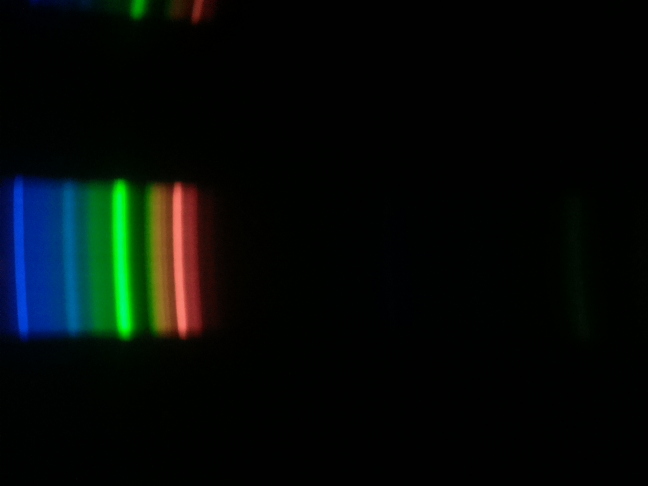

In [231]:
raw